# Homework 5

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import jinja2

from scipy.stats import norm
from functools import partial
from typing import Union, List
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = "{:,.4f}".format

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
path1 = '/Users/matheus/Desktop/finm-portfolio-2024/data/factor_pricing_data.xlsx'
factors = pd.read_excel(path1, sheet_name = 'factors (excess returns)').set_index('Date')
portfolios = pd.read_excel(path1, sheet_name = 'portfolios (excess returns)').set_index('Date')
portfolios.head(5)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0076,0.0285,0.0084,0.1009,-0.0143,0.1002,0.0362,0.0323,0.0048,0.0059,...,0.0158,0.0875,0.0465,-0.0126,0.0430,-0.0283,0.0258,0.0768,0.0308,0.0669
1980-02-29,0.0105,-0.0608,-0.0966,-0.0322,-0.0569,-0.0323,-0.0521,-0.0800,-0.0555,-0.0167,...,-0.0079,-0.0541,-0.0346,-0.0639,-0.0652,-0.0854,-0.0959,-0.0347,-0.0282,-0.0274
1980-03-31,-0.2224,-0.1119,-0.0167,-0.1469,-0.0193,-0.1271,-0.0826,-0.1237,-0.0566,-0.0668,...,-0.0819,-0.1509,-0.1098,-0.0906,-0.1449,-0.0560,-0.0880,-0.2451,-0.1254,-0.1726
1980-04-30,0.0449,0.0766,0.0232,0.0321,0.0830,-0.0529,0.0783,0.0153,0.0304,0.0115,...,0.0420,-0.0103,-0.0312,0.0353,0.0542,0.0728,0.0530,0.0977,0.0447,0.0769
1980-05-31,0.0632,0.0793,0.0457,0.0863,0.0815,0.0509,0.0324,0.0886,0.0560,0.0098,...,0.0564,0.1063,0.1142,0.0877,0.1134,0.0578,0.0557,0.0915,0.0844,0.0685


## Helper Functions
### Performance Summary

In [4]:
def summary_statistics_annualized(returns, annual_factor = 12): #returns index is date
    """This functions returns the summary statistics for the input total/excess returns passed
    into the function"""
    
    
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Volatility'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe Ratio'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    summary_statistics['VaR (0.05)'] = returns.quantile(.05, axis = 0)
    summary_statistics['CVaR (0.05)'] = returns[returns <= returns.quantile(.05, axis = 0)].mean()
    
    return summary_statistics

### Time Series Regression

In [5]:
def time_series_regression(portfolio, factors, FF3F = False, resid = False):
    
    ff_report = pd.DataFrame(index=portfolio.columns)
    bm_residuals = pd.DataFrame(columns=portfolio.columns)

    rhs = sm.add_constant(factors)

    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'alpha_hat'] = res.params['const'] * 12
        ff_report.loc[portf, 'beta_mkt'] = res.params[1]
        if FF3F:
            ff_report.loc[portf, 'Size beta'] = res.params[2] 
            ff_report.loc[portf, 'Value beta'] = res.params[3]
            
        ff_report.loc[portf, 'info_ratio'] = np.sqrt(12) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'treynor_ratio'] = 12 * portfolio[portf].mean() / res.params[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std()*np.sqrt(12))

        if resid:
            bm_residuals[portf] = res.resid # returns a Data Frame of residuals 
            
            
        
    if resid: # returns a Data Frame of residuals 
        return bm_residuals
        
    return ff_report

### Tangency Weights

In [6]:
def tangency_weights(returns, cov_mat = 1):
    
    if cov_mat == 1:
        cov_inv = np.linalg.inv((returns.cov()*12))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag(cov))
        covmat = cov_mat * cov + (1 - cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat * 12))
    
    ones = np.ones(returns.columns.shape)
    mu = returns.mean() * 12
    scaling = 1 / (np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling * (cov_inv @ mu)
    tangency_wts = pd.DataFrame(index=returns.columns, data=tangent_return, columns=['Tangent Weights'])

    return tangency_wts

***

# Section 1: Harvard Case

*This section will not be graded, but it will be discussed in class.*

**Smart Beta Exchange-Traded-Funds and Factor Investing**.

* The case is a good introduction to important pricing factors.
* It also gives useful introduction and context to ETFs, passive vs active investing, and so-called “smart beta” funds.

1. Describe how each of the factors (other than MKT) is measured.1That is, each factor is a portfolio of stocks–which stocks are included in the factor portfolio?

2. Is the factor portfolio...
* long-only
* long-short
* value-weighted
* equally-weighted

4. What steps are taken in the factor construction to try to reduce the correlation between the factors?
5. What is the point of figures 1-6?
6. How is a “smart beta” ETF different from a traditional ETF?
7. Is it possible for all investors to have exposure to the “value” factor?
8. How does factor investing differ from traditional diversification?


If you need more info in how these factor portfolios are created, see Ken French’s website, and the follow- details: 

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor.html

***

# 2. The Factors

Use the data found in `factor_pricing_data.xlsx`.

* FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^{\text{MKT}}$.
* The column header to the market factor is `MKT` rather than `MKT-RF`, but it is indeed already in excess return form.
* The sheet also contains data on five additional factors.
* All factor data is already provided as excess returns

1. Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4.
You now have three additional factors, so let’s compare there univariate statistics. • mean
• volatility
• Sharpe

2. Based on the factor statistics above, answer the following.
(a) Does each factor have a positive risk premium (positive expected excess return)? (b) How have the factors performed since the time of the case, (2015-present)?

3. Report the correlation matrix across the six factors.
* Does the construction method succeed in keeping correlations small?
* Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

4. Report the tangency weights for a portfolio of these 6 factors.
* Which factors seem most important? And Least?
* Are the factors with low mean returns still useful?
* Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

What do you conclude about the importance or unimportance of these styles?

## 2.1

In [7]:
factor_summary = summary_statistics_annualized(factors, annual_factor = 12) #returns index is date
factor_summary[['Mean','Volatility','Sharpe Ratio']]

,Mean,Volatility,Sharpe Ratio
MKT,0.0863,0.1569,0.5499
SMB,0.0083,0.1019,0.0817
HML,0.0258,0.1100,0.2346
RMW,0.0471,0.0832,0.5660
CMA,0.0295,0.0731,0.4041
UMD,0.0627,0.1546,0.4057


## 2.2

Yes, all factors have positive risk premia.

In [8]:
pre_case = summary_statistics_annualized(factors.loc[:'2014']).iloc[:, :3] # take only mean, vol, and sharpe
post_case = summary_statistics_annualized(factors.loc['2015':]).iloc[:, :3]

pre_post = pre_case.join(post_case, lsuffix=' Pre', rsuffix=' Post')
display(pre_post)

,Mean Pre,Volatility Pre,Sharpe Ratio Pre,Mean Post,Volatility Post,Sharpe Ratio Post
MKT,0.0779,0.1561,0.4992,0.1166,0.1603,0.7274
SMB,0.0160,0.1011,0.1582,-0.0195,0.1045,-0.1866
HML,0.0379,0.1028,0.3685,-0.0179,0.1327,-0.1345
RMW,0.0460,0.0858,0.5366,0.0509,0.0733,0.6939
CMA,0.0400,0.0696,0.5751,-0.0084,0.0840,-0.1001
UMD,0.0742,0.1581,0.4692,0.0211,0.1408,0.1497


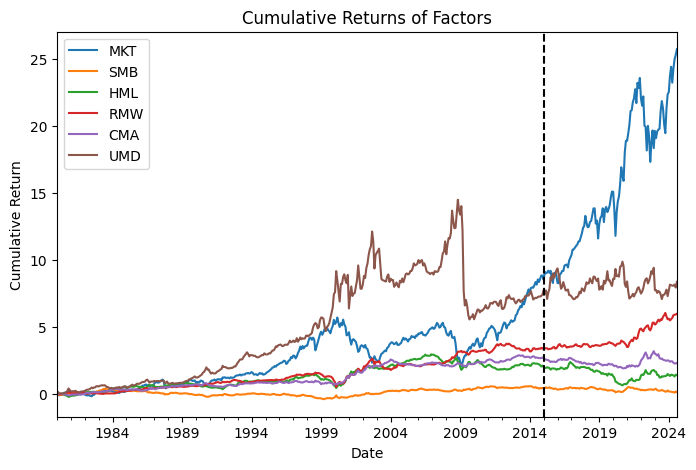

In [9]:
# Plot cumulative returns of factors, add vertical line at 2015
fig, ax = plt.subplots(figsize=(8, 5))
cum_rets = (1 + factors).cumprod() - 1
cum_rets.plot(ax=ax)
ax.axvline('2015', color='k', linestyle='--')
ax.set_title('Cumulative Returns of Factors')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date'); # addd semicolon to prevent a the last line to be produced

MKT has done by far the best, and has been soaring up compared to the other factors, especially after the time of the case (2015). UMD has stayed around flat after the case, although it did well before the time of the case. SMB, CMA, and HML, go from positive expected returns to negative.

Overall, all of the factors except MKT and RMW do worse after the case than before the time of the case.

## 2.3

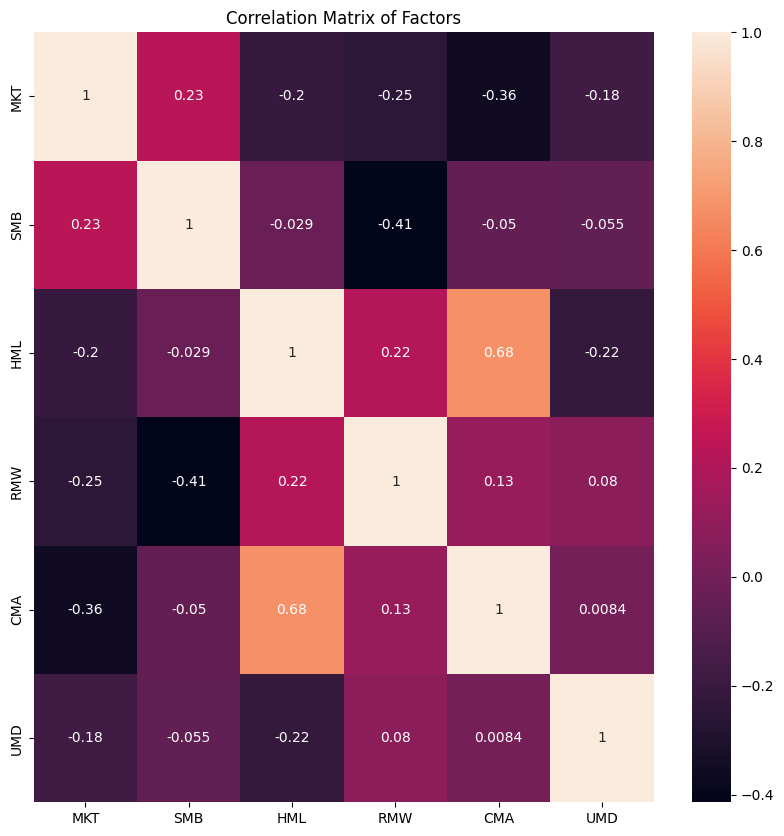

In [10]:
# Plotting the Correlation Matrix in Heatmap
fig, ax = plt.subplots(figsize=(10,10))
correlation_matrix = factors.corr()
ax.set_title('Correlation Matrix of Factors')
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, annot=True);

<b> Does the construction method succeed in keeping correlations small?</b> <br>
With the exception of HML and CMA, which has a correlation of 0.68, all of the factors have quite low correlations. Moreover, a lot of them have negative correlations, which is interesting. RMW and SMB also have a -0.41 correlation, which is somewhat high. The construction method succeed in keeping correlations small.

<b> Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?</b> <br>
I would say so. Given the high correlation HML has to CMA and moderate correlation HML has to RMW, then it is likely that HML is picking up on something similar to CMA. So, out of all of the factors, it could be the most redundant.

Nonetheless, one should be careful to drop HML. Prior to doing that, it is necessary to check the cross-sectional test with and without the Value factor and calculate the weights of the tangency portfolio. If HML shows relevant results, it should not be dropped and, thus, is not redundant.

## 2.4 Report the tangency weights for a portfolio of these 6 factors.
Which factors seem most important? And Least? <br>
Are the factors with low mean returns still useful?<br>
Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?<br>
What do you conclude about the importance or unimportance of these styles?<br>

In [11]:
w_t = tangency_weights(factors)
# combine the tangent weight dataframe with the performance statistics
combined_df = pd.concat([w_t, factor_summary[['Mean','Volatility','Sharpe Ratio']]], axis=1)
combined_df

,Tangent Weights,Mean,Volatility,Sharpe Ratio
MKT,0.2098,0.0863,0.1569,0.5499
SMB,0.0773,0.0083,0.1019,0.0817
HML,-0.0421,0.0258,0.1100,0.2346
RMW,0.3133,0.0471,0.0832,0.5660
CMA,0.3390,0.0295,0.0731,0.4041
UMD,0.1028,0.0627,0.1546,0.4057


### Which factors seem most important? And Least? <br>
CMA and RMW have the highest weights, indicating that they are the most important. HML and SMB have the lowest weights, indicating that they are the least important.

### Are the factors with low mean returns still useful?<br>
Yes, note that CMA and RMW have the highest weights, but definitely do not have the highest mean returns. Both MKT and UMD have better mean returns than CMA and RMW, but lower weights. This again goes back to the fact that when doing MV-optimization, we are not just looking at mean returns, but also covariances.

In [12]:
factors2 = factors[['MKT', 'SMB', 'HML', 'UMD']]
factors2.head()

,MKT,SMB,HML,UMD
Date,,,,
1980-01-31,0.0551,0.0183,0.0175,0.0755
1980-02-29,-0.0122,-0.0157,0.0061,0.0788
1980-03-31,-0.1290,-0.0693,-0.0101,-0.0955
1980-04-30,0.0397,0.0105,0.0106,-0.0043
1980-05-31,0.0526,0.0211,0.0038,-0.0112


In [13]:
w_t2 = tangency_weights(factors2)
w_t2 

,Tangent Weights
MKT,0.3655
SMB,-0.0324
HML,0.3562
UMD,0.3107


<b> Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?<br> </b>
Now MKT, HML, and UMD all have roughly equal and high weights, and SMB has virtually 0 weight. So, I would conclude that SMB is probably not super important, and that MKT, HML, and UMD are all important.

<b> What do you conclude about the importance or unimportance of these styles?<br></b>
When doing MV-optimization, we are not just looking at mean returns, but also covariances. Factors with the highest mean returns are not necessarily considered the most important, and factors with the lowest mean returns are not necessarily considered the least important.

Without using the factors of the FF5F, HML becomes drastically important, which agrees with the redundancy previously mentioned. Furthermore, the Sharpe of the tangency portfolio not using CMA and RMW and the tangency portfolio not using HML are statistically the same, pointing out that it is not clear that we should drop Value and prefer Investment and Profitability factors.

***

# 3. Testing Modern LPMs

Consider the following factor models:
* CAPM: MKT
* Fama-French 3F: MKT, SMB, HML
* Fama-French 5F: MKT, SMB, HML, RMW, CMA
* AQR: MKT, HML, RMW, UMD

We are not saying this is “the” AQR model, but it is a good illustration of their most publicized factors: value, momentum, and more recently, profitability.

For instance, for the AQR model is...

![](../refs/LFP-4-factors.png)

We will test these models with the time-series regressions. Namely, for each asset i, estimate the following regression to test the AQR model:

![](../refs/LFD-4-factors.png)

Data
* PORTFOLIOS: Monthly excess return data on 49 equity portfolios sorted by their industry. Denote these as $\tilde{r}^i$ , for $n = 1, . . . , 49.$

* You do NOT need the risk-free rate data. It is provided only for completeness. The other two tabs are already in terms of excess returns.

1. Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)
* For each regression, report the estimated α and r-squared.
* Calculate the mean-absolute-error of the estimated alphas.
* If the pricing model worked, should these alpha estimates be large or small? Why?
* Based on your MAE stat, does this seem to support the pricing model or not?

2. Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model.
   * Report the MAE statistic for each of these models and compare it with the AQR Model MAE.
   * Which model fits best?
   
3. Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

4. This does not matter for pricing, but report the average (across $n$ estimations) of the time-series regression r-squared statistics.
   * Do this for each of the three models you tested.
   * Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

5. We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.
* Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?4
* Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?

***

For each regression, report the estimated α and r-squared.

In [14]:
from collections import defaultdict
from itertools import product
import statsmodels.api as sm

summary = defaultdict(list)
capm = sm.add_constant(factors['MKT'])
aqr = sm.add_constant(factors[['MKT', 'HML', 'RMW', 'UMD']])
ff3 = sm.add_constant(factors[['MKT', 'SMB', 'HML']])
ff5 = sm.add_constant(factors[['MKT', 'SMB', 'HML', 'RMW', 'CMA']])

col_names = product(['CAPM', 'AQR', 'FF3', 'FF5'], ['Alpha', 'R^2'])
col_names = list(map(lambda x: ' '.join(x), col_names))

summary = pd.DataFrame(0, index=portfolios.columns, columns=col_names)

models = [*zip(['CAPM', 'AQR', 'FF3', 'FF5'], [capm, aqr, ff3, ff5])]

for asset in portfolios.columns: # use portfolios data
    asset_ret = portfolios[asset]
    for name, X in models:
        model = sm.OLS(asset_ret, X).fit()
        summary.loc[asset, f'{name} Alpha'] = model.params[0]
        summary.loc[asset, f'{name} R^2'] = model.rsquared
        
summary[['AQR Alpha', 'AQR R^2']]

,AQR Alpha,AQR R^2
Agric,0.0006,0.3392
Food,0.0006,0.4642
Soda,0.0014,0.3084
Beer,0.0014,0.4208
Smoke,0.0029,0.2735
Toys,-0.0031,0.5083
Fun,0.0025,0.6165
Books,-0.0025,0.6868
Hshld,-0.0007,0.5584
Clths,-0.0015,0.6183


Calculate the mean-absolute-error of the estimated alphas. <br>
If the pricing model worked, should these alpha estimates be large or small? Why?<br>
Based on your MAE stat, does this seem to support the pricing model or not?<br>

If the pricing model worked, the alphas should be statistically zero, meaning small.
This should be the case because all risk premium of any asset should be associated with the risk of the pricing factors.

An alpha means that there is positive (or negative) excess return not associated with pricing factors.

In the time-series, the annualized MAE is 2.3%, which does not support the idea that the pricing model is able to capture all systematic risk.

This mean that, on average, assets have taken 2.3% excess return uncorrelated with any of the pricing factors.

3. 2 Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model.

Report the MAE statistic for each of these models and compare it with the AQR Model MAE. <br>
Which model fits best?

In [15]:
summary.loc[:, summary.columns.str.contains('Alpha')].abs().mean().to_frame('MAE') * 12 # annualized by 12

,MAE
CAPM Alpha,0.0204
AQR Alpha,0.0230
FF3 Alpha,0.0240
FF5 Alpha,0.0314


They are all pretty big, around 2% annualized. The biggest one is for the FF5, and the lowest is for the vanilla CAPM.

The MAE stat does not support the pricing model. We could also run a t-test to see if the difference is statistically significant.

### 3.3 Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?
It's hard to say. All of the models perform worse than the CAPM, so in some sense the only important factor is MKT. However, AQR performs second best, which further indicates that HML or CMA are redundant and should not be used. Yes, Fama and French should probably add the momentum factor to their model.

### 3.4 This does not matter for pricing, but report the average (across estimations) of the time-series regression r-squared statistics.
Do this for each of the three models you tested. <br>
Do these models lead to high time-series r-squared stats? <br>
That is, would these factors be good in a Linear Factor Decomposition of the assets?

In [20]:
summary.loc[:, ~summary.columns.str.contains('Alpha')].mean().to_frame('R^2')

,R^2
CAPM R^2,0.5261
AQR R^2,0.5749
FF3 R^2,0.5715
FF5 R^2,0.5960


Yes, the factor pricing models have relatively high R-Squared in the time-series, meaning that they would be reasonable in LFD.
The best one is the FF5F, followed by AQR, FF3F and, finally, CAPM. The order of the R-Squared is not surprising at all: the factors with the most features have an "in-sample" better fit.

***

## 3.5
We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

In [17]:
def calc_pricing_regression(rets, factors, intercept=True, adj=12):
    if intercept:
        factors = sm.add_constant(factors)
    summary = {f'{k} Beta': [] for k in factors.columns[1:]}
    summary['Alpha']  = []
    summary['R^2']    = []
    for asset in rets.columns:
        model = sm.OLS(rets[asset], factors).fit()
        for k, _ in summary.items():
            try:
                summary[k].append(model.params[k[:-5]])
            except:
                pass
        summary['R^2'].append(model.rsquared)
        summary['Alpha'].append(model.params[0] * adj)
            
    return pd.DataFrame(summary, index=rets.columns)

def calc_cross_sectional_regression(mean_rets, betas, intercept=False):
    if intercept:
        betas = sm.add_constant(betas)
    model = sm.OLS(mean_rets, betas).fit()
    params = model.params.to_frame('Cross Sectional Regression')
    params.loc['R^2'] = model.rsquared
    params.loc['MAE'] = model.resid.abs().mean() 
    return params

frames = []

ts_premia = portfolios.mean() * 12

for name, X in zip(['CAPM', 'AQR', 'FF3', 'FF5'], [capm, aqr, ff3, ff5]):
    pricing_regr = calc_pricing_regression(portfolios, X, intercept=False)
    res = calc_cross_sectional_regression(ts_premia, pricing_regr.iloc[:, :-2], intercept=False)
    res = res.rename({'Cross Sectional Regression': f'{name} CS'}, axis=1)
    frames.append(res)

summary_cs = pd.concat(frames, axis=1).fillna('')

# Move R^2 and MAE to the top
summary_cs = pd.concat([summary_cs.loc[['R^2', 'MAE']], summary_cs.drop(['R^2', 'MAE'])])
summary_cs_betas = summary_cs[summary_cs.index.str.contains('Beta')].copy()
summary_cs_betas.loc[:, 'Time Series'] = factors.mean().values * 12 # mean of each factors, annualized
summary_cs_betas

,CAPM CS,AQR CS,FF3 CS,FF5 CS,Time Series
MKT Beta,0.0861,0.0891,0.1022,0.0965,0.0863
HML Beta,,-0.0387,-0.0152,-0.0310,0.0083
RMW Beta,,0.0437,,0.0336,0.0258
UMD Beta,,0.0607,,,0.0471
SMB Beta,,,-0.0645,-0.0570,0.0295
CMA Beta,,,,-0.0116,0.0627


For MKT, they don't differ that much. Likewise, for UMD and RMW, there isn't a huge difference. However, for SMB, HML, and CMA, there is a big difference, where a lot of the estimated premia are negative!

### Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?


In [18]:
import warnings
warnings.filterwarnings('ignore')

alpha_mae = summary.loc[:, summary.columns.str.contains('Alpha')].abs().mean().to_frame('MAE') * 12

cs_mae = summary_cs.loc[['MAE']].T

mae = pd.concat([alpha_mae, cs_mae])
mae

,MAE
CAPM Alpha,0.0204
AQR Alpha,0.0230
FF3 Alpha,0.0240
FF5 Alpha,0.0314
CAPM CS,0.0204
AQR CS,0.0165
FF3 CS,0.0151
FF5 CS,0.0130


The cross-sectional regional residuals for each of the four models are for the most part smaller than the time-series MAE, with the notable exception of CAPM, which is equal to its time-series MAE.

Adding more factors will increase time-series R^2 but it doesn't necessarily mean it will improve MAE.